In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import os

## Load trained model and save weights:

In [2]:
trained_model = load_model(r'U:\nlp_project\text_summarization\artifacts\model\ts_model.pickle')

In [3]:
trained_model.save_weights(r"U:\nlp_project\text_summarization\artifacts\weights\model_weights")

### load tokenizers:

In [4]:
x_tokenizer_path = os.path.join(r"U:\nlp_project\text_summarization\artifacts\tokenizer\x" , 'x_tokenizer.pkl')
with open(x_tokenizer_path, 'rb') as file:
    x_tokenizer = pickle.load(file)

In [5]:
y_tokenizer_path = os.path.join(r"U:\nlp_project\text_summarization\artifacts\tokenizer\y" , 'y_tokenizer.pkl')
with open(y_tokenizer_path, 'rb') as file:
    y_tokenizer = pickle.load(file)

In [6]:
x_tokenizer,y_tokenizer

(<keras.preprocessing.text.Tokenizer at 0x1a9f8ac0940>,
 <keras.preprocessing.text.Tokenizer at 0x1a9f8b035b0>)

In [7]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 encoder_emb (Embedding)        (None, 150, 500)     13989500    ['input_1[0][0]']                
                                                                                                  
 lstm1 (LSTM)                   [(None, 150, 500),   2002000     ['encoder_emb[0][0]']            
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

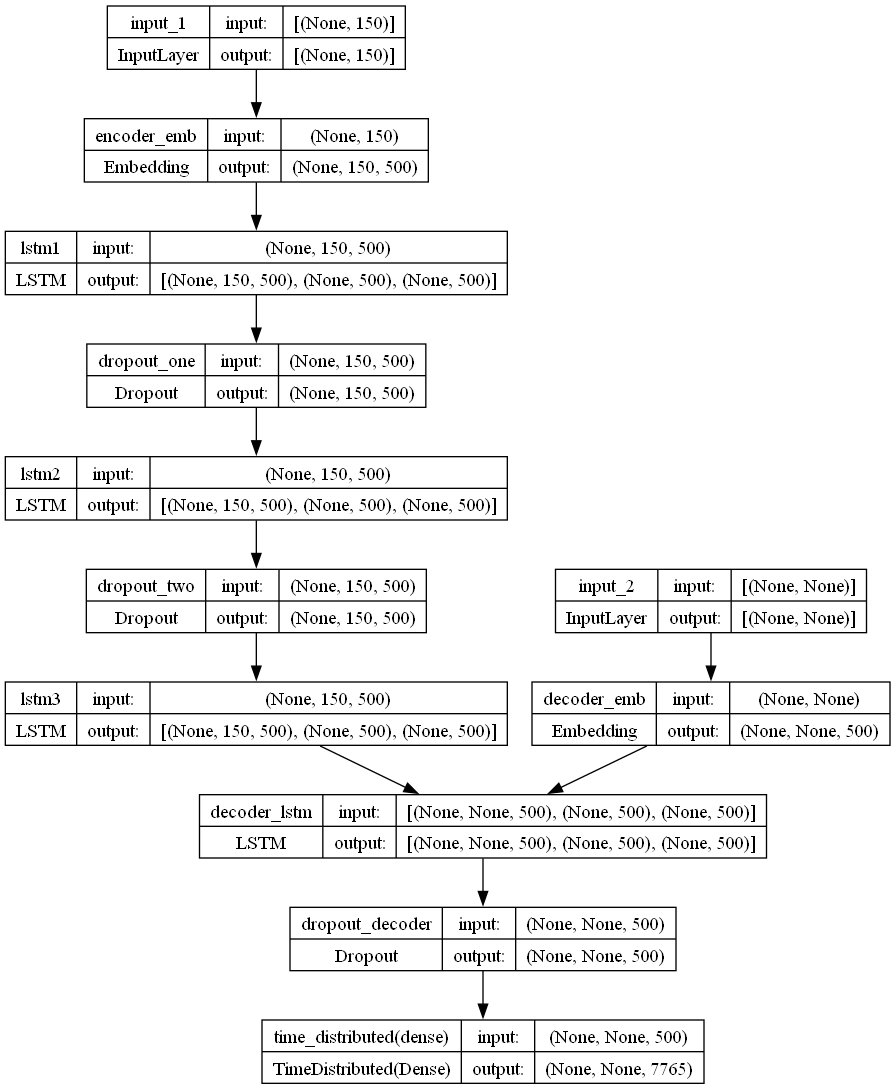

In [8]:
# This code require graphviz to run
from keras.utils import plot_model
plot_model(model=trained_model, show_shapes=True, show_layer_names=True)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
# from constants import *


from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
import keras

In [10]:
for i, layer in enumerate(trained_model.layers):
    print(f"Layer {i}: {layer.name}, {layer.output_shape}")

Layer 0: input_1, [(None, 150)]
Layer 1: encoder_emb, (None, 150, 500)
Layer 2: lstm1, [(None, 150, 500), (None, 500), (None, 500)]
Layer 3: dropout_one, (None, 150, 500)
Layer 4: lstm2, [(None, 150, 500), (None, 500), (None, 500)]
Layer 5: input_2, [(None, None)]
Layer 6: dropout_two, (None, 150, 500)
Layer 7: decoder_emb, (None, None, 500)
Layer 8: lstm3, [(None, 150, 500), (None, 500), (None, 500)]
Layer 9: decoder_lstm, [(None, None, 500), (None, 500), (None, 500)]
Layer 10: dropout_decoder, (None, None, 500)
Layer 11: time_distributed, (None, None, 7765)


In [11]:
x_voc_size = 27979
y_voc_size = 7765
MAX_LEN_TEXT = 150
MAX_LEN_SUMMARY = 100

### Model Creating for inferencing:

In [12]:
latent_dim = 500 
class create_encoder(keras.Model):
    def __init__(self,x_voc_size):
        super().__init__()
        self.encoder_emb = Embedding(x_voc_size, latent_dim,trainable=True,name="encoder_emb")
        self.encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,name="lstm1")
        self.dropout_one = Dropout((0.4),name="dropout_one")
        self.encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,name="lstm2")
        self.dropout_two = Dropout((0.2),name="dropout_two")
        self.encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,name="lstm3")

    def call(self,inputs,*args, **kwargs):
        x = self.encoder_emb(inputs)
        encoder_output1, state_h1, state_c1 = self.encoder_lstm1(x)
        x = self.dropout_one(encoder_output1)
        encoder_output2, state_h2, state_c2 = self.encoder_lstm2(x)
        x = self.dropout_two(encoder_output2)
        encoder_outputs, state_h, state_c = self.encoder_lstm3(x)
        return encoder_outputs,state_h,state_c

In [47]:
encoder_inputs = Input(MAX_LEN_TEXT)
# encoder_inputs = Input(shape=(MAX_LEN_TEXT,))
encoder = create_encoder(x_voc_size)
encoder_outputs,state_h,state_c = encoder.call(encoder_inputs)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [14]:
class create_decoder(keras.Model):
    def __init__(self,y_voc_size):
        super().__init__()
        self.decoder_emb = Embedding(y_voc_size, latent_dim,trainable=True,name="decoder_emb")
        self.decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,name="decoder_lstm") 
        self.dropout_decoder = Dropout((0.3),name="dropout_decoder")
        self.decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
        
    def call(self, decoder_inputs, context_vector=None):
        decoder_emb = self.decoder_emb(decoder_inputs)
        decoder_outputs,decoder_h_state, decoder_c_state = self.decoder_lstm(decoder_emb,initial_state=[context_vector[0], context_vector[1]])
        x = self.dropout_decoder(decoder_outputs)
        decoder_output = self.decoder_dense(x)
        return decoder_output,decoder_h_state, decoder_c_state

In [48]:
context_vector = [state_h,state_c]
decoder_inputs = Input(shape=(None,)) 
decoder = create_decoder(y_voc_size)
decoder_output,decoder_h_state, decoder_c_state = decoder.call(decoder_inputs,context_vector)

decoder_model = Model(inputs = [decoder_inputs] + context_vector, 
                      outputs=[decoder_output, decoder_h_state, decoder_c_state])

In [16]:
loaded_weights = trained_model.get_weights()

In [17]:
for i, layer in enumerate(trained_model.layers):
    print(f"Layer {i}: {layer.name}, {layer.output_shape}")

Layer 0: input_1, [(None, 150)]
Layer 1: encoder_emb, (None, 150, 500)
Layer 2: lstm1, [(None, 150, 500), (None, 500), (None, 500)]
Layer 3: dropout_one, (None, 150, 500)
Layer 4: lstm2, [(None, 150, 500), (None, 500), (None, 500)]
Layer 5: input_2, [(None, None)]
Layer 6: dropout_two, (None, 150, 500)
Layer 7: decoder_emb, (None, None, 500)
Layer 8: lstm3, [(None, 150, 500), (None, 500), (None, 500)]
Layer 9: decoder_lstm, [(None, None, 500), (None, 500), (None, 500)]
Layer 10: dropout_decoder, (None, None, 500)
Layer 11: time_distributed, (None, None, 7765)


#### copying weights from trained model to newly created encoder and decoder:

In [20]:
display(encoder_model.layers)

In [21]:
display(decoder_model.layers)

In [22]:
context_vector = [state_h, state_c]
decoder_model = Model(
[decoder_inputs] + context_vector,
[decoder_output] + [decoder_h_state, decoder_c_state])

In [23]:
loaded_layer_names= [layer.name for _,layer in enumerate(trained_model.layers)]
display(encoder_model.layers)

for layer in encoder_model.layers:
    if layer.name in loaded_layer_names:
        index = loaded_layer_names.index(layer.name)
        print(index,layer.name)
        layer_weights = trained_model.layers[index].weights
    layer.set_weights(layer_weights)

print("--------------------------------------")

0 input_1
1 encoder_emb
2 lstm1
3 dropout_one
4 lstm2
6 dropout_two
8 lstm3
--------------------------------------


In [24]:
print("--------------------------------------")
display(decoder_model.layers)
for layer in decoder_model.layers:
    if layer.name in loaded_layer_names:
        index = loaded_layer_names.index(layer.name)
        print(index,layer.name)
        layer_weights = trained_model.layers[index].get_weights()
        if layer_weights:
            layer.set_weights(layer_weights)

--------------------------------------


5 input_2
7 decoder_emb
9 decoder_lstm
10 dropout_decoder
11 time_distributed


In [25]:
loaded_layer_names= [layer.name for _,layer in enumerate(trained_model.layers)]
display(encoder.layers)

for layer in encoder.layers:
    if layer.name in loaded_layer_names:
        index = loaded_layer_names.index(layer.name)
        print(index,layer.name)
        layer_weights = trained_model.layers[index].weights
    layer.set_weights(layer_weights)

print("--------------------------------------")
display(decoder.layers)
for layer in decoder.layers:
    if layer.name in loaded_layer_names:
        index = loaded_layer_names.index(layer.name)
        print(index,layer.name)
        layer_weights = trained_model.layers[index].weights
    layer.set_weights(layer_weights)

1 encoder_emb
2 lstm1
3 dropout_one
4 lstm2
6 dropout_two
8 lstm3
--------------------------------------


7 decoder_emb
9 decoder_lstm
10 dropout_decoder
11 time_distributed


In [26]:
encoder_model,decoder_model

(<keras.engine.functional.Functional at 0x1a9f9a27d90>,
 <keras.engine.functional.Functional at 0x1a9f9a27ee0>)

In [27]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [28]:
reverse_target_word_index

{1: 'start',
 2: 'end',
 3: 'great',
 4: 'the',
 5: 'good',
 6: 'for',
 7: 'not',
 8: 'and',
 9: 'best',
 10: 'it',
 11: 'my',
 12: 'but',
 13: 'is',
 14: 'to',
 15: 'love',
 16: 'this',
 17: 'coffee',
 18: 'of',
 19: 'taste',
 20: 'dog',
 21: 'tea',
 22: 'in',
 23: 'product',
 24: 'very',
 25: 'flavor',
 26: 'like',
 27: 'these',
 28: 'you',
 29: 'food',
 30: 'delicious',
 31: 'price',
 32: 'too',
 33: 'with',
 34: 'as',
 35: 'tasty',
 36: 'dogs',
 37: 'are',
 38: 'excellent',
 39: 'favorite',
 40: 'ever',
 41: 'so',
 42: 'on',
 43: 'have',
 44: 'loves',
 45: 'better',
 46: 'just',
 47: 'no',
 48: 'free',
 49: 'chips',
 50: 'treat',
 51: 'healthy',
 52: 'yummy',
 53: 'sweet',
 54: 'than',
 55: 'them',
 56: 'what',
 57: 'popcorn',
 58: 'perfect',
 59: 'cup',
 60: 'hot',
 61: 'at',
 62: 'snack',
 63: 'nice',
 64: 'chocolate',
 65: 'all',
 66: 'quality',
 67: 'tastes',
 68: 'really',
 69: 'be',
 70: 'your',
 71: 'little',
 72: 'one',
 73: 'me',
 74: 'treats',
 75: 'easy',
 76: 'stuff',
 

In [39]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    context_vector = [e_h, e_c]
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c]) # inputs = [decoder_inputs] + context_vector
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
            stop_condition = True
        else:
            sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (MAX_LEN_SUMMARY-1)):
                stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence
    return ""

In [40]:
encoder.layers[0]

In [41]:
def seq2summary(input_seq):
    # print(input_seq)
    newString=''
    for i in input_seq:
      # print(i)
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    print("a")
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [42]:
x_val = pd.read_csv(r"U:\nlp_project\text_summarization\artifacts\data\preprocessed_data\x_val.csv")
y_val = pd.read_csv(r"U:\nlp_project\text_summarization\artifacts\data\preprocessed_data\y_val.csv")

In [43]:
enumerate(x_val["cleaned_text"][:10])

In [44]:
list(enumerate(x_val["cleaned_text"][:10]))

[(0,
  'drink lot coffee refuse drink without creamer subscribe save service blessing always creamer ready fridge much cheaper price delivery several reviewers said busted leaked make mess first got mine leaked box none busted leaked removed mine box second time careful removed slowly hand dump container keep mine btw put per cup'),
 (1,
  'first purchase gluten free cheese curls pleasantly surprised taste crunch husband even likes picky snack foods taste better name brand cheese curls less fat calories'),
 (2,
  'getting used using product live everyone else using would run witin days thry run see looks faces still'),
 (3, 'oue two labs love soooo expensive pet stores got bulk dollar'),
 (4,
  'keurig coffee maker great christmas gift last year one pleasures device experimentation various coffee blends worked well others mild bit taste wolfgang puck product one successful experiments keurig machine rich taste still remains smooth strong flavor flavor two coffee drinkers household quit

In [45]:
y_val["cleaned_summary"][0]

'_START_ yummy and convenient  _END_'

In [46]:
for i,text in enumerate(x_val["cleaned_text"][:10]):
    print("Text:",text)
    text = x_tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=MAX_LEN_TEXT, padding='post')
    # print("Original summary:",y_val["cleaned_summary"][i])
    print("Predicted summary:",decode_sequence(text[0].reshape(1,MAX_LEN_TEXT)))
    # print("---------------------------------------------------------------")
    # print('\n')

Text: drink lot coffee refuse drink without creamer subscribe save service blessing always creamer ready fridge much cheaper price delivery several reviewers said busted leaked make mess first got mine leaked box none busted leaked removed mine box second time careful removed slowly hand dump container keep mine btw put per cup
1/1 [==============================] - 0s 15ms/step
Predicted summary:  great product for great price
Text: first purchase gluten free cheese curls pleasantly surprised taste crunch husband even likes picky snack foods taste better name brand cheese curls less fat calories
1/1 [==============================] - 0s 25ms/step
Predicted summary:  great product
Text: getting used using product live everyone else using would run witin days thry run see looks faces still
1/1 [==============================] - 0s 18ms/step
Predicted summary:  great for dogs
Text: oue two labs love soooo expensive pet stores got bulk dollar
1/1 [==============================] - 0s 20ms

In [37]:
for text in x_val["cleaned_text"][:10]:
    print("Text:",text)
    text = x_tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=MAX_LEN_TEXT, padding='post')
    print("Original summary:",seq2summary(text[0]))
    print("Predicted summary:",decode_sequence(text[0].reshape(1,MAX_LEN_TEXT)))
    # print('\n')
    break

Text: drink lot coffee refuse drink without creamer subscribe save service blessing always creamer ready fridge much cheaper price delivery several reviewers said busted leaked make mess first got mine leaked box none busted leaked removed mine box second time careful removed slowly hand dump container keep mine btw put per cup
Original summary: ever wonderful great changs ever tasting pockets problems full dessert cattledogs low pockets jack digestive love rinds like ice water purpose first norman filler in waffles as chocolate year filler than pretzels norman filler ahmad year than seasoning coffee nearly ahmad filter waste bully starbucks an year le baby did with 
1/1 [==============================] - 0s 24ms/step
[[[-1.45375235e-02  3.53976749e-02 -1.40308840e-02 ...  2.56769895e-03
   -2.06912495e-03 -2.38827132e-02]
  [-3.97278927e-02  1.78722978e-01 -6.98727816e-02 ... -4.14660014e-02
    2.33242195e-02 -1.02452539e-01]
  [-3.78654674e-02  4.46361631e-01 -1.35012746e-01 ... -2.

In [38]:
# for i in range(len(x_val)):
#   print("Review:",seq2text(x_val[i]))
#   print("Original summary:",seq2summary(y_val[i]))
#   print("Predicted summary:",decode_sequence(x_val[i].reshape(1,MAX_LEN_TEXT)))
#   print("\n")